In [1]:
import torchvision as thv
import os
import pickle
from torch.utils.data import Subset
import numpy as np

def get_mnist_dataset(root='./mnist_data'):
    # Check if the dataset already exists locally
    if os.path.exists(f'{root}/train_data.pkl') and os.path.exists(f'{root}/val_data.pkl'):
        print("Loading MNIST dataset from local storage...")
        with open(f'{root}/train_data.pkl', 'rb') as f:
            train = pickle.load(f)
        with open(f'{root}/val_data.pkl', 'rb') as f:
            val = pickle.load(f)
    else:
        print("Downloading MNIST dataset...")
        # Download the dataset
        train = thv.datasets.MNIST(root, download=True, train=True)
        val = thv.datasets.MNIST(root, download=True, train=False)
        
        # Save the dataset locally
        os.makedirs(root, exist_ok=True)
        with open(f'{root}/train_data.pkl', 'wb') as f:
            pickle.dump(train, f)
        with open(f'{root}/val_data.pkl', 'wb') as f:
            pickle.dump(val, f)

    print(f"Training dataset shape: {train.data.shape}, Number of targets: {len(train.targets)}")
    print(f"Validation dataset shape: {val.data.shape}, Number of targets: {len(val.targets)}")

    return train, val
    
def split_dataset(train, val):
    import torch
    import numpy as np
    from torch.utils.data import Subset

    # Define the number of classes and target sizes
    num_classes = 10
    target_train_size = 30000
    target_val_size = 5000

    # Initialize lists to hold the indices for the refined datasets
    train_indices = []
    val_indices = []

    # Iterate over each class and collect indices for the split
    for i in range(num_classes):
        # Get indices of all examples from class i in the training and validation sets
        train_class_indices = (train.targets == i).nonzero(as_tuple=True)[0]
        val_class_indices = (val.targets == i).nonzero(as_tuple=True)[0]

        # Convert indices to numpy arrays for shuffling
        train_class_indices_np = train_class_indices.numpy()
        val_class_indices_np = val_class_indices.numpy()

        # Shuffle indices
        np.random.shuffle(train_class_indices_np)
        np.random.shuffle(val_class_indices_np)

        # Calculate split indices, initially aiming to round up
        split_idx_train = (len(train_class_indices_np) + 1) // 2
        split_idx_val = (len(val_class_indices_np) + 1) // 2

        # Adjust split to avoid exceeding overall target sizes
        if len(train_indices) + split_idx_train > target_train_size:
            split_idx_train = target_train_size - len(train_indices)
        if len(val_indices) + split_idx_val > target_val_size:
            split_idx_val = target_val_size - len(val_indices)

        # Add indices to lists
        train_indices.extend(train_class_indices_np[:split_idx_train])
        val_indices.extend(val_class_indices_np[:split_idx_val])

        # Check if we have already reached the target sizes
        if len(train_indices) == target_train_size and len(val_indices) == target_val_size:
            break

    # Create refined datasets
    refined_train = Subset(train, train_indices)
    refined_val = Subset(val, val_indices)

    print(f"Refined training dataset size: {len(refined_train)}")
    print(f"Refined validation dataset size: {len(refined_val)}")

    return refined_train, refined_val

In [4]:
data_path = "./prob3_mnist_data"

train, val = get_mnist_dataset(data_path)
refined_train, refined_val = split_dataset(train, val)

print("Train", train)
print("Val", val)
print("Refined Train", refined_train)
print("Refined Val", refined_val)

Loading MNIST dataset from local storage...
Training dataset shape: torch.Size([60000, 28, 28]), Number of targets: 60000
Validation dataset shape: torch.Size([10000, 28, 28]), Number of targets: 10000
Refined training dataset size: 30000
Refined validation dataset size: 5000
Train Dataset MNIST
    Number of datapoints: 60000
    Root location: ./prob3_mnist_data
    Split: Train
Val Dataset MNIST
    Number of datapoints: 10000
    Root location: ./prob3_mnist_data
    Split: Test
Refined Train <torch.utils.data.dataset.Subset object at 0x000001E70EB10C10>
Refined Val <torch.utils.data.dataset.Subset object at 0x000001E70EB103D0>


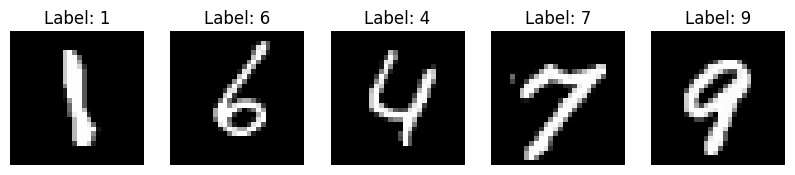

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_images(dataset, num_images=6):
    # Making sure the dataset can be indexed directly
    assert hasattr(dataset, '__getitem__'), "Dataset must support indexing"

    indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 3))
    
    if num_images == 1:
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        
        # MNIST images are 1-channel images, need to be reshaped if in tensor form
        if isinstance(image, torch.Tensor):
            image = image.numpy().squeeze()  # Convert to numpy and remove extra dimensions
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.show()

plot_images(refined_train, num_images=5)

In [ ]:
class linear_t:
    def __init__(self):
        # initialize to appropriate sizes, fill with Gaussian entires
        # normalize to make the Frobenius norm of w, b equal to 1
        self.w, self.b = ...

    def forward(self, h^l):
        h^{l+1} = ...
        # cache h^l in forward because we will need it to compute
        # dw in backward
        self.hl = h^l
        return h^{l+1}

    def backward(self, dh^{l+1}):
        dh^l, dw, db = ...
        self.dw, self.db = dw, db
        # notice that there is no need to cache dh^l
        return dh^l

    def zero_grad(self):
        # useful to delete the stored backprop gradients of the
        # previous mini -batch before you start a new mini -batch
        self.dw, self.db = 0*self.dw, 0*self.db